In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
    # for filename in filenames
    #     print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Table of Contents

* [Set Up The Repository and Packages](#repo)
* [Download the pretrained models](#download)
* [Prepare Dataset for training](#prepare_dataset)
* [Config Modifications for ESRNet](#config_esrnet)
* [Train Real-ESRNet](#train-esrnet)
* [Config Modification for A-ESRGAN](#config_aesrgan)
* [Train A-ESRGAN](#train-aesrgan)
* [Inerence on Test Dataset](#inference)
* [Submission Code](#submission-code)
* [Inference in Colab](#colab-inference)

# Set Up the Repository and Packages <a id='repo'></a>

* If you only want to run this notebook for inerence in colab. Please run all the cells in this section, before jumping to the inference in colab section.

In [2]:
# Clone Real-ESRGAN and enter the Real-ESRGAN
!git clone https://github.com/stroking-fishes-ml-corp/A-ESRGAN.git

Cloning into 'A-ESRGAN'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 111 (delta 11), reused 22 (delta 9), pack-reused 84 (from 1)
Receiving objects: 100% (111/111), 25.36 MiB | 25.19 MiB/s, done.
Resolving deltas: 100% (22/22), done.


In [3]:
%cd A-ESRGAN

/content/A-ESRGAN


In [4]:
# setup the environment
!pip install -r requirements.txt -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 15.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.2/52.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 26.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 92.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 22.0 MB/s eta 0:00:00


In [5]:
!pip install facexlib -q
!pip install gfpgan -q
!pip install ffmpeg-python -q

In [6]:
!pip uninstall basicsr -y

Found existing installation: basicsr 1.4.2
Uninstalling basicsr-1.4.2:
  Successfully uninstalled basicsr-1.4.2


In [7]:
!pip install git+https://github.com/XPixelGroup/BasicSR.git -q

  Preparing metadata (setup.py) ... done


**Note**: If importing basicsr raises error, run the above two cells again

# Download the Pretrained Models <a id="download"></a>

* Required for training A-ESRNET model

Save to experiments/pretrained_models

In [ ]:
cd /kaggle/working/A-ESRGAN

/kaggle/working/A-ESRGAN


In [ ]:
!wget https://github.com/stroking-fishes-ml-corp/A-ESRGAN/releases/download/v1.0.0/RealESRNet_x4plus.pth -P experiments/pretrained_models

In [ ]:
# Download RealESRGan model for Training Real-ESRNet

! wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.1/ESRGAN_SRx4_DF2KOST_official-ff704c30.pth -P experiments/pretrained_models

# Prepare Data <a id="prepare_dataset"></a>

In [ ]:
%mkdir datasets

In [ ]:
%mkdir -p datasets/etdw_train/hr_ds datasets/etdw_train/lr_ds
%cp -r /kaggle/input/enhance-the-dark-world/archive/train/gt/* datasets/etdw_train/hr_ds/
%cp -r /kaggle/input/enhance-the-dark-world/archive/train/train/* datasets/etdw_train/lr_ds

%mkdir -p datasets/etdw_train/meta_info

In [ ]:
# Generate meta info (txt file) for only Ground-Truth images (uncomment below code to run)

# ! python scripts/generate_meta_info.py --input datasets/etdw_train/hr_ds  --root datasets/etdw_train --meta_info datasets/etdw_train/meta_info/meta_info_train.txt

# !python scripts/generate_meta_info_pairdata.py --input datasets/etdw_train/hr_ds datasets/etdw_train/lr_ds --meta_info datasets/etdw_train/meta_info/meta_info_train_pair.txt

In [ ]:
import argparse
import glob
import os

meta_info="datasets/etdw_train/meta_info/meta_info_train_pair.txt"
gt_path="datasets/etdw_train/hr_ds"
lt_path="datasets/etdw_train/lr_ds"
root="datasets/etdw_train"
def generate_meta_info_pairdata(meta_info, gt_path, lt_path, root):
    txt_file = open(meta_info, 'w')
    img_paths_gt = sorted(glob.glob(os.path.join(gt_path, '*')))
    img_paths_lq = sorted(glob.glob(os.path.join(lt_path, '*')))

    assert len(img_paths_gt) == len(img_paths_lq), ('GT folder and LQ folder should have the same length, but got '
                                                    f'{len(img_paths_gt)} and {len(img_paths_lq)}.')

    for img_path_gt, img_path_lq in zip(img_paths_gt, img_paths_lq):
        img_name_gt = os.path.abspath(img_path_gt)
        img_name_lq = os.path.abspath(img_path_lq)
        print(f'{img_name_gt}, {img_name_lq}')
        txt_file.write(f'{img_name_gt}, {img_name_lq}\n')

generate_meta_info_pairdata(meta_info, gt_path, lt_path, root)

In [ ]:
%mkdir -p datasets/etdw_val/meta_info

In [ ]:
meta_info="datasets/etdw_val/meta_info/meta_info_val_pair.txt"
gt_path="/kaggle/input/enhance-the-dark-world/archive/val/gt"
lt_path="/kaggle/input/enhance-the-dark-world/archive/val/val"
root="/kaggle/input/enhance-the-dark-world/archive/val"
generate_meta_info_pairdata(meta_info, gt_path, lt_path, root)

/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00001.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00001.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00002.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00002.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00003.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00003.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00004.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00004.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00005.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00005.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00006.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00006.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00007.png, /kaggle/input/enhance-the-dark-world/archive/val/val/val_00007.png
/kaggle/input/enhance-the-dark-world/archive/val/gt/gt_00008.png, /ka

# Config Modification for ESRNet <a id="config_esrnet"></a>

In [ ]:
%%writefile /kaggle/working/A-ESRGAN/options/train_realesrnet_x4plus_etdw.yml

# general settings
name: train_RealESRNetx4plus_1000k_B12G4
model_type: RealESRNetModel
scale: 4
num_gpu: auto  # auto: can infer from your visible devices automatically. official: 4 GPUs
manual_seed: 0

# ----------------- options for synthesizing training data in RealESRNetModel ----------------- #
gt_usm: True  # USM the ground-truth

# the first degradation process
resize_prob: [0.2, 0.7, 0.1]  # up, down, keep
resize_range: [0.15, 1.5]
gaussian_noise_prob: 0.5
noise_range: [1, 30]
poisson_scale_range: [0.05, 3]
gray_noise_prob: 0.4
jpeg_range: [30, 95]

# the second degradation process
second_blur_prob: 0.8
resize_prob2: [0.3, 0.4, 0.3]  # up, down, keep
resize_range2: [0.3, 1.2]
gaussian_noise_prob2: 0.5
noise_range2: [1, 25]
poisson_scale_range2: [0.05, 2.5]
gray_noise_prob2: 0.4
jpeg_range2: [30, 95]

high_order_degradation: False

gt_size: 256
queue_size: 180

# dataset and data loader settings
datasets:
  train:
    name: ETDW
    type: RealESRGANPairedDataset
    dataroot_gt: datasets/etdw_train/hr_ds/
    dataroot_lq: datasets/etdw_train/lr_ds/
    meta_info: datasets/etdw_train/meta_info/meta_info_train_pair.txt
    io_backend:
      type: disk

    gt_size: 256
    use_hflip: True
    use_rot: False
    phase: 'train'

    # data loader
    use_shuffle: true
    num_worker_per_gpu: 2
    batch_size_per_gpu: 4
    dataset_enlarge_ratio: 1
    prefetch_mode: ~

  # Uncomment these for validation
  val:
    name: validation
    type: RealESRGANPairedDataset
    dataroot_gt: /kaggle/input/enhance-the-dark-world/archive/val/gt/
    dataroot_lq: /kaggle/input/enhance-the-dark-world/archive/val/val/
    meta_info: datasets/etdw_val/meta_info/meta_info_val_pair.txt
    phase: 'val'
    io_backend:
      type: disk
    gt_size: 256
    use_hflip: False
    use_rot: False

# network structures
network_g:
  type: RRDBNet
  num_in_ch: 3
  num_out_ch: 3
  num_feat: 64
  num_block: 23
  num_grow_ch: 32

# path
path:
  pretrain_network_g: /kaggle/working/A-ESRGAN/experiments/pretrained_models/ESRGAN_SRx4_DF2KOST_official-ff704c30.pth
  param_key_g: params_ema
  strict_load_g: true
  resume_state: ~

# training settings
train:
  ema_decay: 0.999
  optim_g:
    type: Adam
    lr: !!float 2e-4
    weight_decay: 0
    betas: [0.9, 0.99]

  scheduler:
    type: MultiStepLR
    milestones: [1000000]
    gamma: 0.5

  total_iter: 30000
  warmup_iter: -1  # no warm up

  # losses
  pixel_opt:
    type: L1Loss
    loss_weight: 1.0
    reduction: mean

# Uncomment these for validation
# validation settings
val:
  val_freq: !!float 5e2
  save_img: false

  metrics:
    psnr: # metric name, can be arbitrary
      type: calculate_psnr
      crop_border: 4
      test_y_channel: false

# logging settings
logger:
  print_freq: 100
  save_checkpoint_freq: !!float 5e2
  use_tb_logger: false
  # wandb:
  #   project: ~
  #   resume_id: ~

# dist training settings
# dist_params:
#   backend: nccl
#   port: 29500

Overwriting /kaggle/working/A-ESRGAN/options/train_realesrnet_x4plus_etdw.yml


# Train Real-ESRNet <a id="train-esrnet"></a>

* This model is used to train A-ESRGAN [below](#train-aesrgan)

In [ ]:
# !python train.py -opt options/train_realesrnet_x4plus_etdw.yml --auto_resume

# Config File Modification For A-ESRGAN <a id="config_aesrgan"></a>


* for training aesrgan
* using: Best: 39.3054 @ 4000 iter

Copy the models trained for Real-ESRNet under pretrained-models directory

In [ ]:
mkdir /kaggle/working/A-ESRGAN/experiments/finetuned_models

In [ ]:
!cp /kaggle/working/experiments/train_RealESRNetx4plus_1000k_B12G4/models/net_g_4500.pth /kaggle/working/A-ESRGAN/experiments/finetuned_models/

In [ ]:
%%writefile /kaggle/working/A-ESRGAN/options/train_multiaesrgan_x4plus_etdw.yml

# GENERATE TIME: Sun Dec 15 14:41:18 2024
# CMD:
# train.py --auto_resume -opt options/train_multiaesrgan_x4plus_etdw.yml


# general settings
name: train_multi_A_ESRGANx4plus # training states are stored here.
model_type: AESRGANModel
scale: 4
num_gpu: auto  # auto: can infer from your visible devices automatically. official: 4 GPUs
manual_seed: 0

# ----------------- options for synthesizing training data in RealESRGANModel ----------------- #
# USM the ground-truth
l1_gt_usm: True
percep_gt_usm: True
gan_gt_usm: False

# the first degradation process
resize_prob: [0.2, 0.7, 0.1]  # up, down, keep
resize_range: [0.15, 1.5]
gaussian_noise_prob: 0.5
noise_range: [1, 30]
poisson_scale_range: [0.05, 3]
gray_noise_prob: 0.4
jpeg_range: [30, 95]

# the second degradation process
second_blur_prob: 0.8
resize_prob2: [0.3, 0.4, 0.3]  # up, down, keep
resize_range2: [0.3, 1.2]
gaussian_noise_prob2: 0.5
noise_range2: [1, 25]
poisson_scale_range2: [0.05, 2.5]
gray_noise_prob2: 0.4
jpeg_range2: [30, 95]

high_order_degradation: False

gt_size: 256
queue_size: 180

# dataset and data loader settings
datasets:
  train:
    name: ETDW
    type: RealESRGANPairedDataset
    dataroot_gt: datasets/etdw_train/hr_ds/
    dataroot_lq: datasets/etdw_train/lr_ds/
    meta_info: datasets/etdw_train/meta_info/meta_info_train_pair.txt
    io_backend:
      type: disk

    gt_size: 256
    use_hflip: True
    use_rot: False
    phase: 'train'

    # data loader
    use_shuffle: true
    num_worker_per_gpu: 2
    batch_size_per_gpu: 4
    dataset_enlarge_ratio: 1
    prefetch_mode: ~

  # Uncomment these for validation
  val:
    name: validation
    type: RealESRGANPairedDataset
    dataroot_gt: /kaggle/input/enhance-the-dark-world/archive/val/gt/
    dataroot_lq: /kaggle/input/enhance-the-dark-world/archive/val/val/
    meta_info: datasets/etdw_val/meta_info/meta_info_val_pair.txt
    phase: 'val'
    io_backend:
      type: disk
    gt_size: 256
    use_hflip: False
    use_rot: False

# network structures
network_g:
  type: RRDBNet
  num_in_ch: 3
  num_out_ch: 3
  num_feat: 64
  num_block: 23 # 23
  num_grow_ch: 32

network_d:
  type: multiscale
  num_in_ch: 3
  num_feat: 64
  num_D: 2

# path
path:
  # use the pre-trained Real-ESRNet model
  pretrain_network_g: /kaggle/working/A-ESRGAN/experiments/finetuned_models/net_g_4500.pth # finetuned
  param_key_g: params_ema
  strict_load_g: true
  resume_state: ~

# training settings
train:
  ema_decay: 0.999
  optim_g:
    type: AdamW
    lr: !!float 1e-4
    weight_decay: !!float 1e-4 # 0
    betas: [0.9, 0.99]

  optim_d:
    type: AdamW
    lr: !!float 1e-4
    weight_decay: !!float 1e-4 # 0
    betas: [0.9, 0.99]

  scheduler:
    type: MultiStepLR
    milestones: [30000]
    gamma: 0.5

  total_iter: 1000
  warmup_iter: -1  # no warm up

  # losses
  pixel_opt:
    type: L1Loss # L1Loss
    loss_weight: 1.0 # 1
    reduction: mean
  # perceptual loss (content and style losses)
  perceptual_opt:
    type: PerceptualLoss
    layer_weights:
      # before relu
      'conv1_2': 0.1
      'conv2_2': 0.1
      'conv3_4': 1
      'conv4_4': 1
      'conv5_4': 1
    vgg_type: vgg19
    use_input_norm: true
    perceptual_weight: !!float 1.0
    style_weight: 1.0 # 0
    range_norm: false
    criterion: l2 # l1
  # gan loss
  gan_opt:
    type: GANLoss
    gan_type: lsgan #vanilla
    real_label_val: 1.0
    fake_label_val: 0.0
    loss_weight: !!float 1e-1

  net_d_iters: 1 # 1
  net_d_init_iters: 0

# Uncomment these for validation
# validation settings
val:
  val_freq: !!float 277.0 # 1e2
  save_img: True
  metrics:
    psnr: # metric name, can be arbitrary
      type: calculate_psnr
      crop_border: 4
      test_y_channel: false
    ssim:
      type: calculate_ssim
      crop_border: 4
      test_y_channel: false


# logging settings
logger:
  print_freq: 277
  save_checkpoint_freq: !!float 277.0
  use_tb_logger: false # true
#  wandb:
#    project: ~
#    resume_id: ~

# dist training settings
# dist_params:
#   backend: nccl
#   port: 29500

Overwriting /kaggle/working/A-ESRGAN/options/train_multiaesrgan_x4plus_etdw.yml


# Train A-ESRGAN <a id="train-aesrgan"></a>

In [ ]:
# rm -r /kaggle/working/experiments/train_multi_A_ESRGANx4plus

In [ ]:
!python train.py --auto_resume -opt options/train_multiaesrgan_x4plus_etdw.yml

Disable distributed.
Path already exists. Rename it to /kaggle/working/experiments/train_multi_A_ESRGANx4plus_archived_20241215_164418
2024-12-15 16:44:18,516 INFO: 
                ____                _       _____  ____
               / __ ) ____ _ _____ (_)_____/ ___/ / __ \
              / __  |/ __ `// ___// // ___/\__ \ / /_/ /
             / /_/ // /_/ /(__  )/ // /__ ___/ // _, _/
            /_____/ \__,_//____//_/ \___//____//_/ |_|
     ______                   __   __                 __      __
    / ____/____   ____   ____/ /  / /   __  __ _____ / /__   / /
   / / __ / __ \ / __ \ / __  /  / /   / / / // ___// //_/  / /
  / /_/ // /_/ // /_/ // /_/ /  / /___/ /_/ // /__ / /<    /_/
  \____/ \____/ \____/ \____/  /_____/\____/ \___//_/|_|  (_)
    
Version Information: 
	BasicSR: 1.4.2
	PyTorch: 2.4.0
	TorchVision: 0.19.0
2024-12-15 16:44:18,516 INFO: 
  name: train_multi_A_ESRGANx4plus
  model_type: AESRGANModel
  scale: 4
  num_gpu: 1
  manual_seed: 0
  l1_gt_usm: True
  

# Inference on Test Dataset <a id="inference"></a>

Specify the model (generator) path

Run `inference_aesrgan.py` with following arguments

```
--model_path=<path of the model>
--input=<path to directory where images for inference is kept>
--output=<where to store the inference generated files>
--suffix=<siffix for the names of inferred files>
```

In [ ]:
!python inference_aesrgan.py --model_path=/kaggle/working/experiments/train_multi_A_ESRGANx4plus/models/net_g_277.pth --input=/kaggle/input/enhance-the-dark-world/archive/test --output=results/aesrgan_1k_test --suffix=""

/kaggle/working/A-ESRGAN/aesrgan/utils.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path)
Testing 0 test_00001
Testing 1 test_00002
Testin

# Submission Code <a id="submission-code"></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from PIL import Image

def images_to_csv(folder_path, output_csv):
    data_rows = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path).convert('L')
            image_array = np.array(image).flatten()[::8]
            # Replace 'test_' with 'gt_' in the ID
            image_id = filename.split('_.')[0].replace('test_', 'gt_')
            print(image_id)
            data_rows.append([image_id, *image_array])
    column_names = ['ID'] + [f'pixel_{i}' for i in range(len(data_rows[0]) - 1)]
    df = pd.DataFrame(data_rows, columns=column_names)
    df.to_csv(output_csv, index=False)
    print(f'Successfully saved to {output_csv}')

folder_path = 'results/aesrgan_1k_test'
output_csv = 'submission.csv'
images_to_csv(folder_path, output_csv)

gt_00036
gt_00017
gt_00005
gt_00040
gt_00038
gt_00013
gt_00001
gt_00018
gt_00009
gt_00020
gt_00044
gt_00045
gt_00046
gt_00021
gt_00035
gt_00002
gt_00048
gt_00012
gt_00004
gt_00054
gt_00015
gt_00025
gt_00039
gt_00016
gt_00055
gt_00010
gt_00043
gt_00052
gt_00030
gt_00011
gt_00056
gt_00037
gt_00034
gt_00028
gt_00027
gt_00024
gt_00019
gt_00058
gt_00051
gt_00014
gt_00042
gt_00008
gt_00053
gt_00059
gt_00031
gt_00026
gt_00047
gt_00041
gt_00033
gt_00007
gt_00006
gt_00050
gt_00049
gt_00057
gt_00022
gt_00029
gt_00060
gt_00003
gt_00023
gt_00032
Successfully saved to submission.csv


# Inference In Colab <a id="colab-inference"/>

* You are required set test folder according to your need in `--input`
* The results will be stored in `results` folder as specified in `--output`
* You are in A-ESRGAN directory

In [8]:
ls

aesrgan/  inference_aesrgan.py  NIQE_Script/  requirements.txt  Training.md
docs/     inputs/               options/      scripts/          train.py
figures/  LICENSE               README.md     setup.py          Visualization_Script/


In [9]:
mkdir test

* Upload your desired files into test folder

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
ls /content/drive/MyDrive/@Degree/Sep-2024/DLP/NPPE-3/21f1002049/

21F1002049.csv    net_d_277.pth  train_multiaesrgan_x4plus_etdw.yml
21F1002049.ipynb  net_g_277.pth  train_train_multi_A_ESRGANx4plus_20241216_065700.log


In [21]:
!python inference_aesrgan.py --model_path=/content/drive/MyDrive/@Degree/Sep-2024/DLP/NPPE-3/21f1002049/net_g_277.pth --input=./test --output=results/ --suffix=""

/content/A-ESRGAN/aesrgan/utils.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loadnet = torch.load(model_path)
Testing 0 oldphoto6


In [22]:
from PIL import Image
import matplotlib.pyplot as plt

In [23]:
img_old = Image.open("/content/A-ESRGAN/test/oldphoto6.png")

(-0.5, 255.5, 255.5, -0.5)

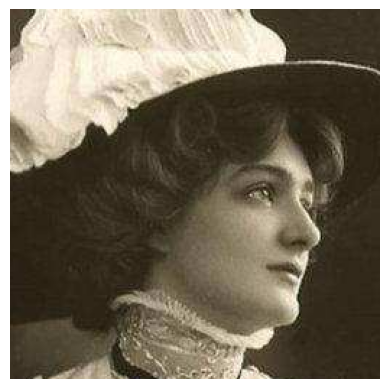

In [24]:
plt.imshow(img_old)
plt.axis("off")

In [25]:
img_sr = Image.open("/content/A-ESRGAN/results/oldphoto6_.png")

(-0.5, 1023.5, 1023.5, -0.5)

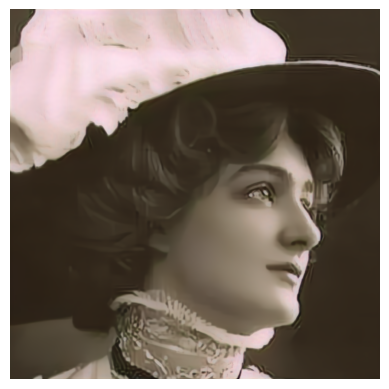

In [26]:
plt.imshow(img_sr)
plt.axis("off")

# Thank You!